In [1]:
import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *

In [2]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [3]:
#Load preprocess data
LK = np.array(pd.read_csv ('../data/processed_data/LK.csv'))
y = np.array(LK[:,-1],dtype=int)
LK = LK[:,0:-1]


In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)

In [5]:
print(LK.shape, len(pred))
acc = model.score_
print(acc)

(610, 1379) 610
0.136


In [6]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (102.0, 648.0, 0.1574074074074074, 0.37777777777777777, 0.9876770942283921, 0.136, 0.9967757412916227, 0.864, 0.6222222222222222)


In [7]:
def split_data_cv(x:np.array, y:np.array, kfold:int):
    """ Split the data for CV. Keep cells of same family together.
  
      parameters:
      y: np.array,
        family of each data points
      x: np.array,
        gene expression of each data points
      kfold: int,
        number of fold for CV
        

      returns:
      split_x : np.array of np.array,
        split normalized data, split_x[k] = kth split
      split_y : np.array of np.array,
        split families data   """
    
    #Get all families indices
    ind_families = np.unique(y)
    N_families = len(ind_families)
    N_fold_family = math.ceil(N_families/kfold)
    
    
    #Randomly choose the families in each split    
    np.random.shuffle(ind_families)
    
    fam_split = np.empty(kfold, dtype=object)
    for i in range (0,kfold):
        fam_split[i] = []
        
    for i in range (0, kfold):
        temp = ind_families[i*N_fold_family:((i+1)*N_fold_family)]
        fam_split[i].append(temp)
      
    #Get the data from splitted families: split_x, split_y
    split_x = np.empty(kfold, dtype=object)
    split_y = np.empty(kfold, dtype=object)
    for i in range (0,kfold):
        split_x[i] = []
        split_y[i] = []
        
    for i in range (0,kfold):
        ind = np.squeeze(fam_split[i])
     
        mask = np.isin(y, ind)
        temp_x = x[mask]
        temp_y = y[mask]
        
        split_x[i].append(temp_x)
        split_y[i].append(temp_y)
            
        
    return split_x, split_y



In [8]:
fam = np.array([1,7,1,1,7,8,10,4,6])
x = np.array([1,68,3,20,9,2,24,8,20])

split_x, split_y = split_data_cv(x,fam,3)

# Split data into Kfold (kfold = 5)

In [9]:
split_x, split_y = split_data_cv(LK,y,5)

# Mutual information maximizer (MIM)

(485, 1379) (125, 1379) (485,) (125,)
(486, 1379) (124, 1379) (486,) (124,)
(490, 1379) (120, 1379) (490,) (120,)
(491, 1379) (119, 1379) (491,) (119,)
(488, 1379) (122, 1379) (488,) (122,)
training 0.2624575282004308 0.006827700370294153
test 0.5231034675712003 0.0678348059290524


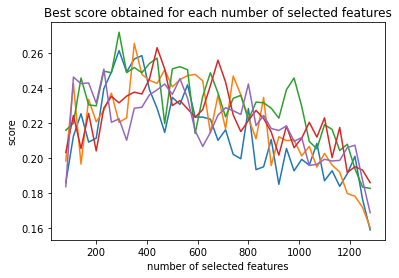

In [10]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    N = np.arange(80,1300,30)
    subset, train_score = MIM(y_train, x_train, FamiliesClusters, compute_precision,True,N, 3, plot=True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Anova F test

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    N = np.arange(80,1300,30)
    subset, train_score = ANOVA(y_train, x_train, FamiliesClusters, compute_ratio,True,N, plot=True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

(485, 1379) (125, 1379) (485,) (125,)
(486, 1379) (124, 1379) (486,) (124,)
(490, 1379) (120, 1379) (490,) (120,)


# Stimulated annealing

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = stimulated_annealing(y_training, x_training, FamiliesClusters, compute_sensitivity,True, 1400, 0.1, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Genetic feature selection algorithm

In [ ]:


score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = genetic_fs(y_train,x_train,FamiliesClusters,compute_sensitivity,True, 500, 0.5, 0.2, 50, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Hybrid methods

# Mutual information and stimulated annealing

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_stimulated_annealing(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([400]), 3, 5000, 0.05, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Mutual information and genetic feature selection

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_genetic_fs(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([700]), 3,  300, 0.5, 0.2, 120, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Baseline with preselected genes 

In [ ]:
#Load preprocess data
LK = np.array(pd.read_csv ('../data/processed_data/LSK.csv'))
y = np.array(LK[:,-1],dtype=int)
LK = LK[:,0:-1]

In [ ]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)

In [ ]:
print(LK.shape, len(pred))
acc = model.score_
print(acc)

In [ ]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Split data into Kfold (kfold = 5)

In [ ]:
split_x, split_y = split_data_cv(LK,y,5)

# Mutual information maximizer (MIM)

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    N = np.arange(80,1300,30)
    subset, train_score = MIM(y_train, x_train, FamiliesClusters, compute_precision,True,N, 3, plot=True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Anova F test

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    N = np.arange(80,1300,30)
    subset, train_score = ANOVA(y_train, x_train, FamiliesClusters, compute_ratio,True,N, plot=True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Stimulated annealing

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = stimulated_annealing(y_training, x_training, FamiliesClusters, compute_sensitivity,True, 1400, 0.1, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Genetic feature selection algorithm

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = genetic_fs(y_train,x_train,FamiliesClusters,compute_sensitivity,True, 500, 0.5, 0.2, 50, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Mutual information and stimulated annealing

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_stimulated_annealing(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([400]), 3, 5000, 0.05, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Mutual information and genetic feature selection

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_genetic_fs(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([700]), 3,  300, 0.5, 0.2, 120, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)